# 강화 학습

In [1]:
# 공통
import numpy as np
import os
import sys

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 16.1 보상을 최적화하기 위한 학습
- 강화 학습에서 소프트웨어 에이전트는 관측을 하고 주어진 환경에서 행동을 하여 그 결과로 보상을 얻음
- 에이전트의 목적은 보상의 장기간 기대치를 최대로 만드는 행동을 학습하는 것(양스 보상은 기쁨으로, 음수 보상은 아픔으로 생각할 수 있음)
    - 양수 보상은 없을수도 있음(예를 들어 미로 탈출의 경우 타입 스텝마다 음수 보상을 받으므로 최대한 빨리 탈출해야 함)

## 16.2 정책 탐색
- 에이전트가 행동을 결정하기 위해 사용하는 알고리즘을 정책이라고 함
- 이 정책은 생각할 수 있는 어떤 알고리즘도 될 수 있으며 심지어 결정적일 필요도 없음
    - 확률적 정책
    - 유전 알고리즘 정책
    - 그래디언트 정책
    - 그 외 다양함

## 16.3 OpenAI 짐
- 강화 학습의 도전과제 중 하나는 에이전트를 훈련시키기 위해 먼저 작업 환경을 마련해야 한다는 것
- 아타리 게임 플레이를 학습할 에이전트를 프로그래밍하려면 아타리 게임 시뮬레이터가 필요할 것 -> OpenAI 짐을 이용

In [2]:
import gym

env = gym.make('MsPacman-v0') # make() ==> 환경을 만듬(MsPacman 환경 버전 0을 로드)

In [3]:
obs = env.reset() # reset() 메서드를 호출하여 환경을 초기화
obs.shape # [width, height, channels] 크기의 3D 넘파이 배열로 저장되어 있는 RGB 이미지(다른 환경에서는 다른 오브젝트가 반환될 수 있음)

(210, 160, 3)

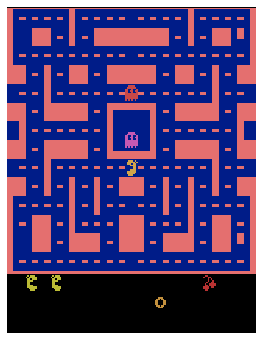

In [4]:
img = env.render(mode="rgb_array") # render() ==> 화면에 환경(아래 그림과 같은)을 출력

plt.figure(figsize=(5,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# 이 환경에서는 렌더링된 이미지가 관측과 동일(하지만 많은 경우에 그렇지 않음)
(img == obs).all()

True

In [6]:
# 환경을 그리기 위한 유틸리티 함수
def plot_environment(env, figsize=(5,6)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [7]:
# 에이전트는 "행동 공간"(가능한 행동의 모음)에서 하나의 행동을 선택
env.action_space # action_space ==> 이 환경의 액션 공간

Discrete(9)

- Discrete(9)는 가능한 행동이 정수 0에서부터 8까지있다는 의미
- 이는 조이스틱의 9개의 위치(0=중앙, 1=위, 2=오른쪽, 3=왼쪽, 4=아래, 5=오른쪽위, 6=왼쪽위, 7=오른쪽아래, 8=왼쪽아래)에 해당

In [8]:
# 그다음 환경에게 플레이할 행동을 알려주고 게임의 다음 단계를 진행(왼쪽으로 110번을 진행하고 왼쪽아래로 40번을 진행)
env.reset()
for step in range(110):
    env.step(3) #왼쪽
for step in range(40):
    env.step(8) #왼쪽아래

In [9]:
# step() 함수는 중요한 여러 객체를 반환함
obs, reward, done, info = env.step(0)

In [10]:
obs.shape # 앞서 본 것처럼 관측은 보이는 환경을 설명(여기서는 210x160 RGB 이미지)

(210, 160, 3)

In [11]:
reward # 마지막 스텝에서 받을 수 있는 보상

0.0

In [12]:
done # 게임이 종료되면 환경은 done=True를 반환

False

In [13]:
info # 환경의 내부 상태에 관한 추가 정보를 제공하는 딕셔너리(디버깅에는 유용하지만 에이전트는 학습을 위해서 이 정보를 사용하면 안됨)

{'ale.lives': 3}

In [14]:
# 10번의 스텝마다 랜덤한 방향을 선택하는 식으로 전체 게임(3개의 팩맨)을 플레이하고 각 프레임을 저장
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

In [15]:
# 애니메이션으로 보기 위한 함수
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

In [16]:
video = plot_animation(frames)
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줌

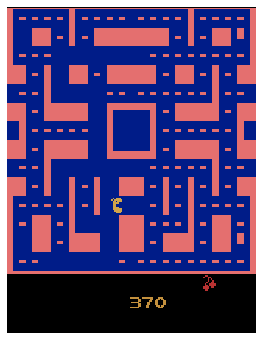

In [17]:
plot_environment(env)

In [18]:
env.close() # 환경을 더 이상 사용하지 않으면 환경을 종료하여 자원을 반납

##### 간단한 Cart-Pole 환경
- Cart-Pole은 아주 간단한 환경으로 왼쪽이나 오른쪽으로 움직일 수 있는 카트와 카트 위에 수직으로 서 있는 막대로 구성
- 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여서 막대가 넘어지지 않도록 유지시켜야 함

In [19]:
env = gym.make("CartPole-v0")

In [20]:
obs = env.reset()
obs # 관측은 4개의 부동소수로 구성된 1D 넘파이 배열([카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도])

array([ 0.00208193, -0.04906192,  0.02642724,  0.02959474])

In [21]:
# 렌더링 이슈 해결하기
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # 문제없음, OpenAI 짐의 렌더링 함수를 사용합니다
except Exception:
    openai_cart_pole_rendering = False  # 가능한 X 서버가 없다면, 자체 렌더링 함수를 사용합니다

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # OpenAI 짐의 렌더링 함수를 사용합니다
        return env.render(mode="rgb_array")
    else:
        # Cart-Pole 환경을 위한 렌더링 (OpenAI 짐이 처리할 수 없는 경우)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # 파랑 초록 빨강
        pole_col = 0x669acc # 파랑 초록 빨강

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

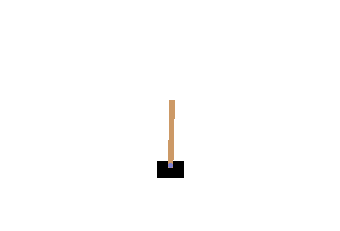

In [22]:
plot_cart_pole(env, obs)

In [23]:
env.action_space # 단 두개의 행동이 존재(0: 왼쪽 가속, 1: 오른쪽 가속)

Discrete(2)

In [24]:
# 막대가 넘어지기 전까지 카트를 왼쪽으로 밀어보기
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

(-0.5, 599.5, 399.5, -0.5)

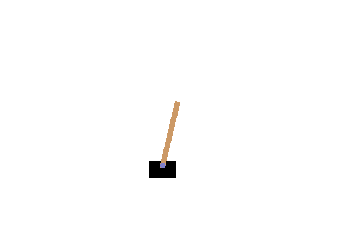

In [25]:
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")

In [26]:
img.shape

(400, 600, 3)

In [27]:
# 환경을 다시 초기화하고 이번에는 오른쪽으로 밀어보기
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

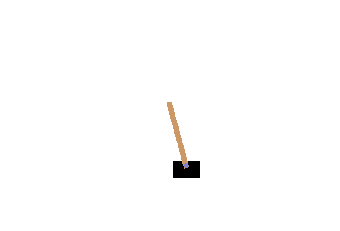

In [28]:
plot_cart_pole(env, obs)

##### 하드 코딩 정책
- 막대가 넘어지지 않기 위해서는 정책을 만들어야 함 이를 위해 간단한 하드 코딩 정책을 코딩
- 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 밀고 반대의 경우는 오른쪽으로 밈

In [29]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

In [30]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줌

## 16.4 신경망 정책
- 앞서 하드코딩한 정책과 마찬가지로 이 신경망은 관측을 입력받고 실행할 행동을 출력(좀 더 정확히 말하면 각 행동에 대한 확률을 추정)
- 출력받은 행동을 확률에 따라 랜덤하게 선택하는 것
    - 행동을 선택하는 것이 아닌 확률 기반으로 하는 이유는 에이전트가 새로운 행동을 탐험하는 것과 잘 할 수 있는 행동을 활용하는 것 사이에 균형을 맞추게 함
    - 또한 각 관측이 환경에 대한 완전한 상태를 담고 있어 과거의 행동과 관측을 무시해도 됨

In [31]:
import tensorflow as tf

# 1. 네트워크 구조를 설정
n_inputs = 4  # == env.observation_space.shape[0] (입력의 개수는 관측 공간의 크기 -> CartPole의 경우 4)
n_hidden = 4  # 간단한 작업이므로 너무 많은 뉴런이 필요하지 않음
n_outputs = 1 # 왼쪽으로 가속할 확률을 출력
initializer = tf.variance_scaling_initializer()

# 2. 네트워크를 만듬(여기서는 가능한 행동이 2개이므로 로지스틱을 썼지만, 만약 두 개보다 많으면 소프트맥스를 활성화 함수로 써야함)
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=initializer)

# 3. 추정된 확률을 기반으로 랜덤하게 행동을 선택합니다
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1) # multinomial() ==> 랜덤하게 행동을 선택하기 위해(확률에 기준)

init = tf.global_variables_initializer()

C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yoo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


In [32]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

In [33]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줌
# 더 잘 학습될 필요가 있음

## 16.5 행동 평가: 신용 할당 문제
- 각 스텝에서 가장 좋은 행동이 무엇인지 알고 있다면 추정된 확률과 타깃 확률 사이의 크로스엔트로피를 최소화하도록 평소처럼 신경망을 훈련할 수 있음
- 하지만 강화 학습에서 에이전트가 얻을 수 있는 도움은 보상뿐으로 보상은 일반적으로 드물고 지연되어 나타남
    - 예를 들어 100번의 행동 끝에 막대가 쓰러졌다면, 그 책임이 몇 번째 행동에 있는지 알기 쉽지 않음
    - 이를 신용 할당 문제라고 함 -> 즉, 에이전트가 보상받았을 때 어떤 행동 덕분인지 알기 어려움
- 이 문제를 해결하기 위해 흔히 사용하는 전략은 행동이 일어난 후 각 단계마다 할인 계수를 적용한 보상을 모두 합하여 행동을 평가하는 것
    - 할인 계수가 0에 가까우면 먼 미래의 보상이 중요하게 취급되지 않을 것
    - 할인 계수가 1에 가까우면 먼 미래의 보상이 현재의 보상만큼 중요하게 고려될 것
    - 전형적인 할인 계수의 값은 0.95~0.99

In [34]:
# 다음 코드는 같은 신경망이지만 타깃 확률 y와 훈련 연산(cross_entropy, optimizer, training_op)을 추가
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # 행동 0(왼쪽)에 대한 확률
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
# 동일한 네트워크를 동시에 10개의 다른 환경에서 플레이하고 1,000번 반복동안 훈련(완료되면 환경을 리셋)
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # angle<0 이면 proba(left)=1. 이 되어야 하고 그렇지 않으면 proba(left)=0. 이 되어야 합니다
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [36]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [37]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줌

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


## 16.6 정책 그래디언트
- 앞서 언급한 것처럼 PG 알고리즘은 높은 보상을 얻는 방향의 그래디언트로 정책의 파라미터를 최적화하는 알고리즘
- 다음은 많이 사용하는 한 가지 방법
    - 1. 먼저 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그래디언트를 계산(아직 그래디언트를 적용하지는 않음)
    - 2. 몇 번의 에피소드를 실행한 다음, 각 행동의 점수를 계산(앞 절에서 설명한 방식을 사용)
    - 3. 한 행동의 점수가 양수면 이 행동이 좋은 것임을 의미하므로 미래에 선택될 가능성이 높도록 앞서 계산한 그래디언트를 적용하고 반대로 음수면 이 행동이 나쁜 것임을 의미하므로 미래의 행동이 덜 선택되도록 반대의 그래디언트를 적용(이는 각 그래디언트 벡터와 그에 상응하는 행동의 점수를 곱하면 됨)
    - 4. 마지막으로 모든 결과 그래디언트 벡터를 평균 내어 경사 하강법 스텝을 수행

In [38]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # 행동 0(왼쪽)에 대한 확률
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action) # 타깃 확률 생성
# 선택된 행동이 가장 가능성 있는 최선의 행동인것처럼 다룰 것
# 선택된 행동이 행동 0(왼쪽)이면 타깃 확률은 1.0이고, 행동 1(오른쪽)이면 0.0이 되어야 함

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) # 비용 함수(크로스엔트로피) 정의
optimizer = tf.train.AdamOptimizer(learning_rate) # Adam 옵티마이저
grads_and_vars = optimizer.compute_gradients(cross_entropy) # 그래디언트 계산(minimize() 대신 compute_gradients() 호출)
gradients = [grad for grad, variable in grads_and_vars] # 모든 그래디언트 저장
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [39]:
# 원본 보상을 받아서 할인된 전체 보상을 계산하는 함수
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

# 여러 에피소드에 걸친 결과를 정규화하는 함수
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [40]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [41]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [42]:
env = gym.make("CartPole-v0")

n_games_per_update = 10 # 10번의 에피소드마다 정책을 훈련
n_max_steps = 1000 # 에피소드별 최대 스텝
n_iterations = 250 # 훈련 반복 횟수
save_iterations = 10 # 10번의 에피소드마다 모델을 저장
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\r반복: {}".format(iteration), end="")
        all_rewards = [] # 각 에피소드에 대한 모든 원본 보상의 리스트
        all_gradients = [] # 각 에피소드의 스텝마다 저장된 그래디언트
        for game in range(n_games_per_update):
            current_rewards = [] # 현재 에피소드에서 얻은 모든 원본 보상
            current_gradients = [] # 현재 에피소드에서 얻은 모든 그래디언트
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) # 한 개의 관측
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # 여기까지 10번의 에피소드(n_games_per_update)에서 정책을 실행했고,
        # 앞서 언급한 알고리즘을 사용해 정책을 업데이트할 준비가 됨
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            # 그래디언트와 행동 점수를 곱하고 평균을 계산
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

반복: 249

In [43]:
env.close()

In [44]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


## 16.7 마르코프 결정 과정
- 정해진 개수의 상태를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이(과거의 상태에 상관없이 한 쌍에만 의존)

In [45]:
# Q-가치 반복 알고리즘
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ] # s0에서, 행동 a0이 선택되면 0.7의 확률로 상태 s0로 가고 0.3의 확률로 상태 s1로 가는 식

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("상태 (+보상):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("전체 보상 =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("요약: 평균={:.1f}, 표준 편차={:1f}, 최소={}, 최대={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
상태 (+보상): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) ... 전체 보상 = 160
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) ... 전체 보상 = 130
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 10
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) ... 전체 보상 = 180
상태 (+보상): 0 (10) 0 1 (-50) 2 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) ... 전체 보상 = -70
요약: 평균=121.2, 표준 편차=129.755477, 최소=-330, 최대=470

policy_random
상태 (+보상): 0 0 0 0 0 0 0 0 0 0 ... 전체 보상 = 0
상태 (+보상): 0 (10) 0 0 1 (-50) 2 1 (-50) 2 (40) 0 0 (10) 0 (10) ... 전체 보상 = 30
상태 (+보상): 0 0 0 (10) 0 0 1 1 1 1 1 (-50) ... 전체 보상 = -50
상태 (+보상): 0 0 0 (10) 0 0 0 (10) 0 0 0 0 ... 전체 보상 = 10
상태 (+보상): 0 0 0 1 (-50) 2 (40) 0 0 0 (10) 0 1 (-50) ... 전체 보상 = 30
요약: 평균=-23.2, 표준 편차=88.672002, 최소=-400, 최대=220

policy_safe
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 1 1 ... 전체 보상 = 60
상태 (+보상): 0 1 1 1 1 1 1 1 1 1 ... 전체 보상 = 0
상태 (+보상): 0

## 16.8 시간차 학습과 Q-러닝
- 시간차 학습(TD 학습)은 가치 반복 알고리즘과 매우 비슷하지만, 에이전트가 MDP에 대해 일부 정보만 알고 있을 때를 다룰 수 있도록 변형한 것
    - 일반적으로 에이전트가 초기에 가능한 상태와 행동만 알고 있고 다른 것은 모른다고 가정
    - 에이전트는 탐험 정책을 사용해 MDP를 탐험하고 TD 학습 알고리즘이 실제로 관측된 전이와 보상에 근거하여 상태 가치 추정을 업데이트하는 방식

In [47]:
# Q-러닝 구현
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps): # 충분히 반복하면 Q-가치에 수렴하게 될 것
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # 그리디한 정책
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [48]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [49]:
q_values

array([[39.59093659, 38.93869394, 35.55927839],
       [18.70530829,        -inf, 20.30294145],
       [       -inf, 73.44174534,        -inf]])

In [50]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("요약: 평균={:.1f}, 표준 편차={:1f}, 최소={}, 최대={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

상태 (+보상): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... 전체 보상 = 70
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 170
상태 (+보상): 0 1 (-50) 2 (40) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) ... 전체 보상 = 210
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) ... 전체 보상 = 150
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 430
요약: 평균=122.4, 표준 편차=133.440578, 최소=-350, 최대=610



#### 16.8.1 탐험 정책
- 탐험 정책이 MDP를 충분히 탐험해야 Q-러닝이 작동
- 완전한 랜덤 정책이 결국에는 모든 상태와 전이를 여러 번 경험하겠지만, 시간이 오래 걸리므로 그리디 정책을 사용해야 함
- 다른 방법으로는 탐험의 가능성에 의존하는 대신 이전에 많이 시도하지 않았던 행동을 시도하도록 탐험 정책을 강조하는 방법도 존재

#### 16.8.2 근사 Q-러닝과 딥 Q-러닝
- Q-러닝의 주요 문제는 많은 상태와 행동을 가진 대규모의 MDP에 적용하기 어렵다는 것(너무나 많은 경우의 수가 존재할 수 있음)
    - 따라서 적절한 개수의 파라미터를 사용하는 근사 Q-러닝을 사용
    - Q-가치를 추정하기 위해 사용하는 DNN을 심층 Q-네트워크(DQN)라 하고
    - 근사 Q-러닝을 위해 DQN을 사용하는 것이 심층 Q-러닝이라 함

## 16.9
- 환경의 제약으로 인해 생략

## 16.10 연습문제

#### 1. 강화 학습을 어떻게 정의할 수 있나요? 지도 학습이나 비지도 학습과 어떻게 다른가요?
- 강화 학습(RL)은 머신러닝의 한 분야로, 주어진 환경에서 시간이 지남에 따라 보상이 최대화하는 행동을 할 수 있는 에이전트를 만드는 것을 목표로 합니다. RL과 일반 지도 학습에는 많은 차이점이 있습니다.
1. 지도 학습과 비지도 학습의 목적은 데이터에 있는 패턴을 찾아 사용해 예측을 만드는 것입니다. 강화 학습의 목적은 좋은 정책을 찾는 것입니다.
2. 지도 학습과 달리 에이전트에 올바른 정답이 명시적으로 주어지지 않습니다. 에이전트는 시행착오를 통해 학습해야 합니다.
3. 비지도 학습과 달리 보상을 통한 감독의 형태가 있습니다. 에이전트에 어떻게 작업을 수행하라고 알려주지 않지만 일을 잘했는지 또는 실패했는지 알려줍니다.
4. 강화 학습 에이전트는 보상을 얻기 위해 새로운 방식을 찾는 환경의 탐험과 이미 알고 있는 보상 방법을 활용하는 것 사이에 적절한 균형을 가져야 합니다. 이와는 반대로 지도 학습과 비지도 학습 시스템은 탐험에 대해 신경 쓸 필요가 없습니다. 즉, 주어진 훈련 데이터를 주입하면 됩니다.
5. 지도 학습과 비지도 학습에서 훈련 샘플은 일반적으로 독립적입니다. 강화 학습에서는 연속된 관측이 보통 독립적이지 않습니다. 에이전트가 잠시 동안 움직이지 않고 환경의 같은 영역에 머물러 있을 수 있습니다. 그러므로 연속된 관측은 매우 상호 연관되어 있습니다. 어떤 경우에는 훈련 알고리즘이 독립적인 관측을 얻을 수 있도록 재현 메모리를 사용합니다.

#### 2. 이 장에서 언급하지 않은 가능한 RL 애플리케이션을 세 가지 생각해보세요. 각 애플리케이션의 환경은 무엇인가요? 에이전트는 무엇인가요? 가능한 행동은 무엇인가요? 보상은 무엇인가요?
- 16장에서 언급하지 않은 가능한 몇 가지 강화 학습 애플리케이션은 다음과 같습니다.
- 음악 개인화
    - 환경은 사용자의 개인화된 웹 라디오입니다. 에이전트는 사용자에게 다음에 어떤 노래를 재생할지 결정하는 소프트웨어입니다. 가능한 행동은 카탈로그에 있는 어떤 노래(사용자가 좋아하는)를 재상하거나 광고(사용자가 관심있을)를 재생하는 것입니다. 에이전트는 노래를 들을 때마다 작은 보상을 받고 광고를 들을 때마다 큰 보상을 받습니다. 노래나 광고를 스킵하면 음수의 보상을 받고 사용자가 더 이상 듣지 않고 떠나면 큰 음수의 보상을 받습니다.
- 마케팅
    - 환경은 회사의 마케팅 부서입니다. 에이전트는 고객 프로파일과 구매 이력을 바탕으로 어떤 고객에게 홍보 메일을 보낼지 결정하는 소프트웨어입니다. 에이전트는 홍보 메일의 발송 비용에 대해 음수의 보상을 받고 이 캠페인으로부터 발생된 예상 매출을 양수의 보상을 받습니다.
- 제품 배송
    - 에이전트는 배송 트럭 전체를 제어하여 창고에서 실어야 할 것과 도착할 곳, 전달할 물건 등을 결정합니다. 상품이 제시간 안에 배송되면 양수의 보상을 받고 배송이 지연되면 음수의 보상을 받습니다.

#### 3. 할인 계수는 무엇인가요? 할인 계수를 바꾸면 최적의 정책이 바뀔 수 있나요?
- 행동의 가치를 추정할 때 강화 학습 알고리즘은 일반적으로 이 행동으로 받을 수 있는 모든 보상을 더합니다. 이때 즉시 받을 수 있는 보상은 큰 가중치를 주고 나중에 받을 수 있는 보상은 낮은 가중치를 줍니다(먼 미래보다 가까운 장래의 영향이 더 크다고 가정). 이를 모델링하기 위해 매 타임 스텝마다 할인 계수가 적용됩니다. 예를 들어 할인 계수가 0.9일 때 2번의 타임 스텝 후에 받을 100의 보상은 0.9^2 x 100 = 81로 행동의 가치를 추정합니다. 할인 계수를 현재에 비해 미래의 가치를 얼마로 보는지의 척도로 생각할 수 있습니다. 이 값이 1에 매우 가까우면 미래의 가치는 현재와 거의 동일합니다. 만약 0에 가까우면 당장의 보상만 의미가 있을 것입니다. 당연히 이 값은 최적의 정책에 큰 영향을 미칩니다. 미래를 가치 있게 여기면 종국의 보상을 기대하고 당장의 고통을 감내하려고 하는 반면, 미래의 가치를 중요하지 않게 생각하면 미래를 위한 투자보다 찾을 수 있는 당장의 보상을 선택할 것입니다.

#### 4. 강화 학습 에이전트의 성능은 어떻게 측정할 수 있나요?
- 강화 학습 에이전트의 성능을 측정하려면 간단하게 얻은 보상을 모두 더하면 됩니다. 시뮬레이션 환경에서는 많은 에피소드를 수행하고 평균적으로 얻은 전체 보상을 확인합니다.

#### 5. 신용 할당 문제가 무엇인가요? 언제 이런 문제가 발생하나요? 어떻게 이를 감소시킬 수 있나요?
- 신용 할당 문제는 강화 학습 에이전트가 보상을 받을 때 이 보상에 기여한 행동을 알아내기 위한 직접적인 방법이 없다는 것입니다. 일반적으로 행동과 그에 따른 보상 사이에는 많은 지연이 있습니다(예를 들어 아타리 퐁 게임에서 에이전트가 볼을 튕기는 순간과 점수를 얻는 순간 사이에는 수십 개의 타임 스텝이 존재). 이 문제를 감소시키는 한 가지 방법은 가능하면 에이전트에 단기 보상을 제공하는 것입니다. 이는 보통 작업에 대한 사전 지식을 필요로 합니다. 예를 들어 체스 게임을 플레이하는 에이전트를 만들려고 한다면 게임이 이겼을 대만 보상을 주는 대신 상대 말을 잡았을 때도 보상을 줄 수 있습니다.

#### 6. 재현 메모리를 사용하는 이유는 무엇인가요?
- 에이전트는 종종 한동안 환경의 동일한 지역에 머물러 있을 수 있어서 이 기간 동안에 얻은 경험이 매우 비슷할 것입니다. 이는 학습 알고리즘에 일종의 편향을 일으킵니다. 이 영역에서는 정책이 튜닝되지만 이 지역을 벗어나는 순간 잘 작동하지 못할 것입니다. 이 문제를 해결하기 윟 ㅐ재현 메모리를 사용할 수 있습니다. 가장 최근의 경험만을 학습에 사용하는 대신 에이전트가 최근 경험과 최근이 아닌 경험들을 담은 버퍼에 기초하여 학습하게 됩니다.

#### 7. 오프-폴리시 RL 알고리즘이 무엇인가요?
- 오프-폴리시 RL 알고리즘은 에이전트가 최적이 아닌 정책을 따르는 동안 최적 정책의 가치(예를 들어 에이전트가 최적으로 행동한다면 각 상태에서 기대할 수 있는 할인된 보상의 합)를 학습니다. Q-러닝이 이 알고리즘의 좋은 예입니다. 반대로 온-플리시 알고리즘은 탐험과 활용을 포함해서 에이전트가 실제로 실행한 정책의 가치를 학습합니다.